# Sierra Leone Solar Data: Exploratory Data Analysis

This notebook performs exploratory data analysis on the Sierra Leone solar dataset to better understand the data quality, patterns, and relationships between variables.

**Objectives:**
- Profile the data and identify missing values
- Clean the data by handling outliers and missing values
- Perform time series analysis on key solar variables
- Analyze relationships between variables
- Explore environmental factors affecting solar radiation

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import os

# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

# Import custom utility functions
import sys
sys.path.append('..')
from src.utils.utils import (load_data, missing_values_report, detect_outliers, 
                            clean_data, plot_time_series, plot_correlation_heatmap, 
                            plot_scatter, plot_bubble_chart, plot_histogram, save_dataframe)

# Create data directory if it doesn't exist
Path('../data').mkdir(exist_ok=True)

## 1. Data Loading and Initial Inspection

In [17]:
file_path = '../data/sierraleone-bumbuna.csv'
df = pd.read_csv(file_path)

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Timestamp'].min()} to {df['Timestamp'].max()}")
df.head()

# Check data types
df.info()

Dataset shape: (525600, 19)
Date range: 2021-10-30 00:01:00 to 2022-10-30 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600

Summary Statistics for Numeric Columns:
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-30 12:00:30.000000768     201.957515     116.376337   
min              2021-10-30 00:01:00     -19.500000      -7.800000   
25%              2022-01-29 06:00:45      -2.800000      -0.300000   
50%              2022-04-30 12:00:30       0.300000      -0.100000   
75%              2022-07-30 18:00:15     362.400000     107.000000   
max              2022-10-30 00:00:00    1499.000000     946.000000   
std                              NaN     298.495150     218.652659   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      113.720571     206.643095     198.114691      26.319394   
min       -17.900000       0.000000       0.000000      12.300000   
25%        -3.800000       0.000000       0.000000   

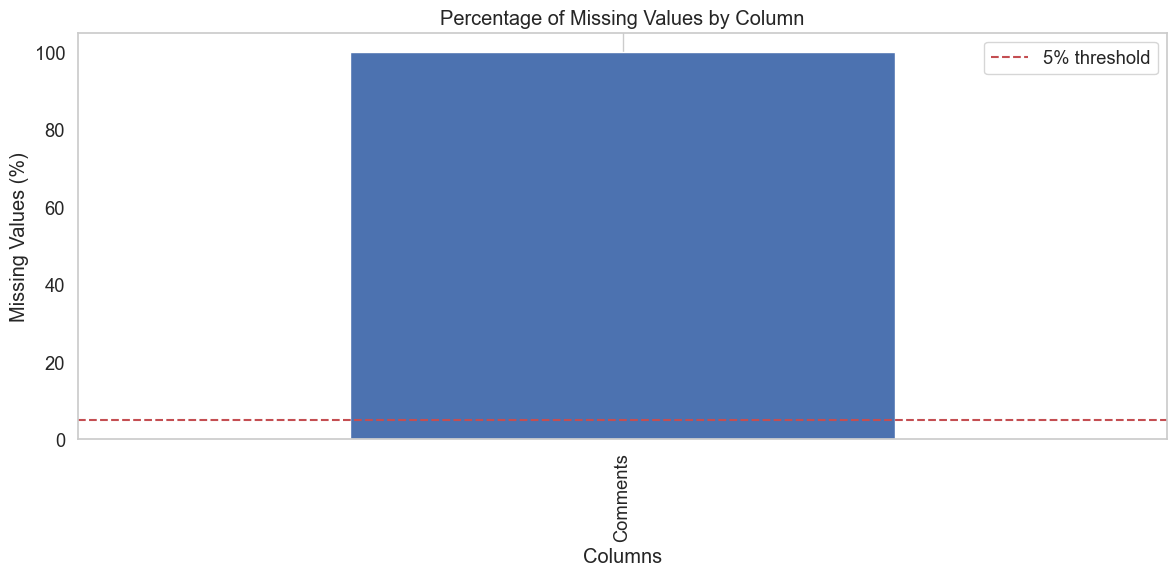

In [18]:
numeric_stats = df.describe()
print("Summary Statistics for Numeric Columns:")
print(numeric_stats)

# Generate missing values report
missing_report = missing_values_report(df)
print("\nMissing Values Report (columns with >5% nulls):")
print(missing_report)

# Create a bar chart of missing values percentage
missing_percentages = df.isna().mean() * 100
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)

if len(missing_percentages) > 0:
    plt.figure(figsize=(12, 6))
    missing_percentages.plot(kind='bar')
    plt.axhline(y=5, color='r', linestyle='--', label='5% threshold')
    plt.title('Percentage of Missing Values by Column')
    plt.ylabel('Missing Values (%)')
    plt.xlabel('Columns')
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 2. Outlier Detection and Data Cleaning

In [19]:
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Detect outliers using Z-score method
outliers = detect_outliers(df, key_columns, z_threshold=3)

# Count outliers per column
outlier_counts = outliers.sum()
outlier_percentages = outlier_counts / len(df) * 100
print("Outlier Summary:")
for col in outliers.columns:
    print(f"{col}: {outlier_counts[col]} outliers ({outlier_percentages[col]:.2f}%)")

# Combine outliers into a single flag per row
df['has_outlier'] = outliers.any(axis=1)
print(f"\nTotal rows with at least one outlier: {df['has_outlier'].sum()} ({df['has_outlier'].mean()*100:.2f}%)")

Outlier Summary:
GHI: 2477 outliers (0.47%)
DNI: 7586 outliers (1.44%)
DHI: 2986 outliers (0.57%)
ModA: 1604 outliers (0.31%)
ModB: 2041 outliers (0.39%)
WS: 3967 outliers (0.75%)
WSgust: 3665 outliers (0.70%)

Total rows with at least one outlier: 16292 (3.10%)


In [20]:
# Clean data by handling missing values and outliers
columns_to_clean = key_columns + ['Tamb', 'RH', 'WD', 'BP']

def clean_outliers(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        if col not in df.columns:
            continue
            
        # Calculate z-scores
        z_series = np.abs(stats.zscore(df_clean[col].dropna()))
        z_series = pd.Series(z_series, index=df_clean[col].dropna().index)
        
        # Get indices where z_score > 3
        outlier_indices = z_series[z_series > 3].index
        
        # Replace outliers with NaN
        df_clean.loc[outlier_indices, col] = np.nan
    
    return df_clean

In [21]:
# First replace outliers with NaN
df_clean = clean_outliers(df, columns_to_clean)

# Then impute missing values with median
df_clean = clean_data(df_clean, columns_to_clean, strategy='median')

# Check remaining missing values after cleaning
print("Missing values after cleaning:")
print(df_clean[columns_to_clean].isna().sum())

# Save cleaned DataFrame to CSV
clean_data_path = '../data/sierraleone_clean.csv'
save_dataframe(df_clean, clean_data_path)

Missing values after cleaning:
GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
Tamb      0
RH        0
WD        0
BP        0
dtype: int64
Data saved to ../data/sierraleone_clean.csv


## 3. Time Series Analysis

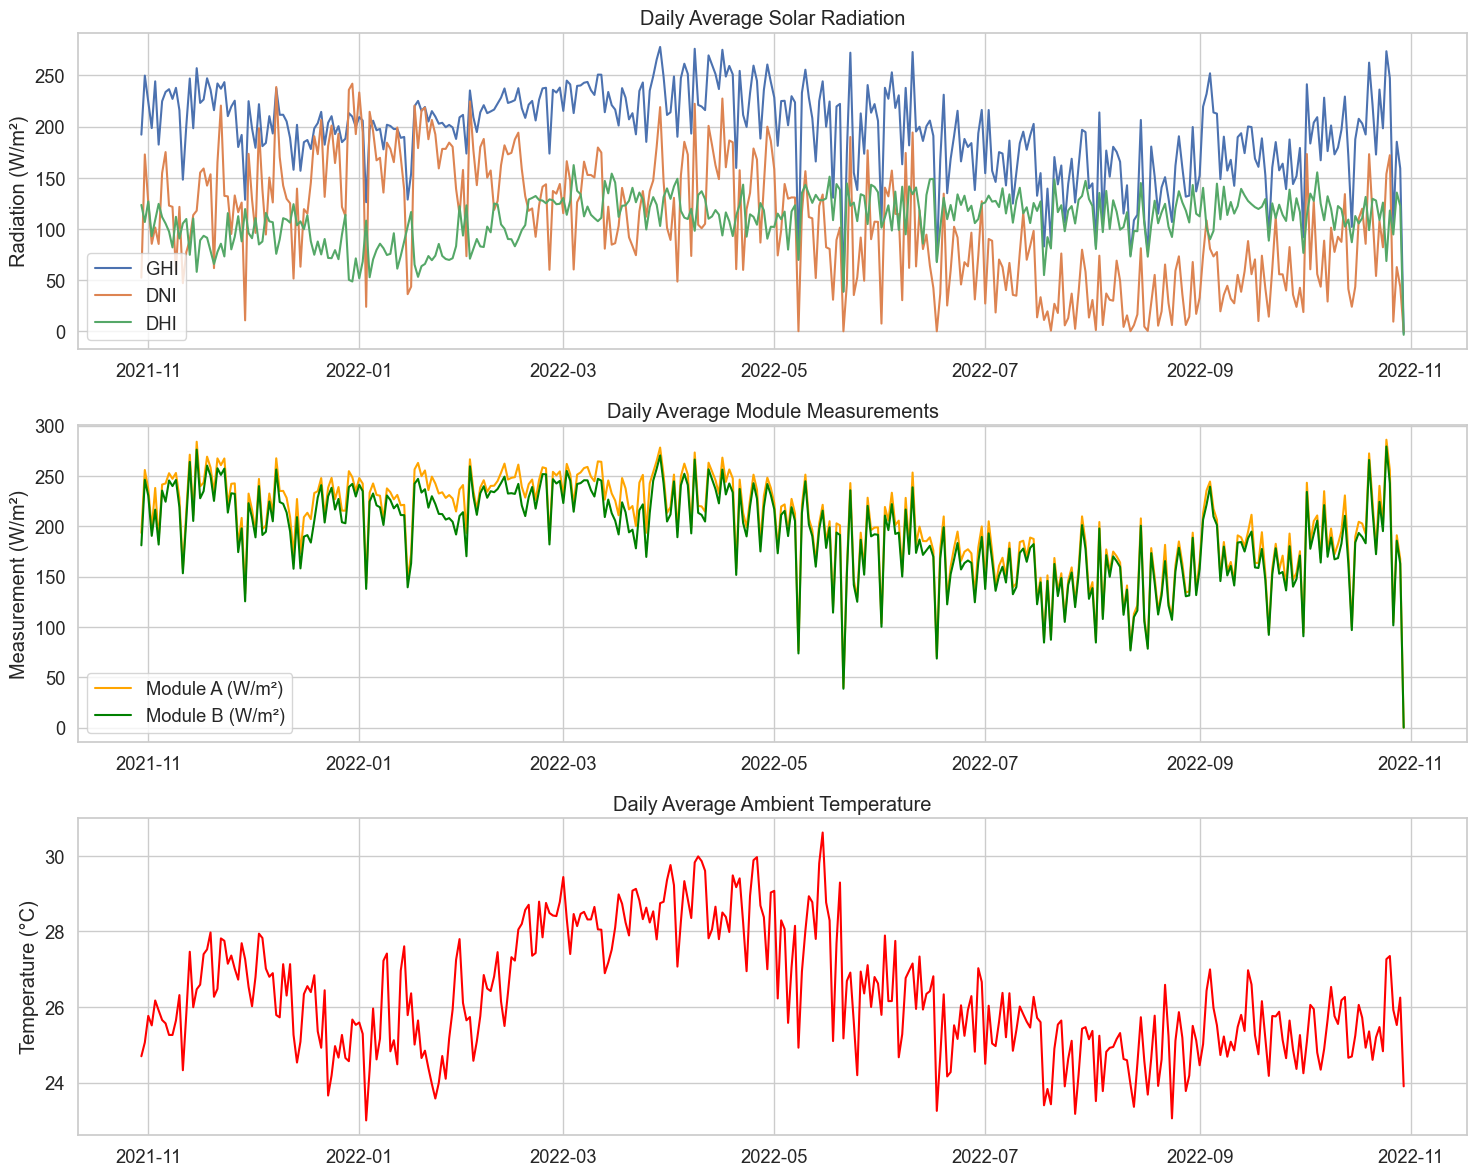

In [22]:
daily_data = df_clean.set_index('Timestamp').resample('D').mean().reset_index()

# Plot GHI, DNI, DHI, Tamb over time
plt.figure(figsize=(15, 12))

# Solar Radiation Variables
plt.subplot(3, 1, 1)
plt.plot(daily_data['Timestamp'], daily_data['GHI'], label='GHI')
plt.plot(daily_data['Timestamp'], daily_data['DNI'], label='DNI')
plt.plot(daily_data['Timestamp'], daily_data['DHI'], label='DHI')
plt.title('Daily Average Solar Radiation')
plt.ylabel('Radiation (W/m²)')
plt.grid(True)
plt.legend()

# Module Temperatures
plt.subplot(3, 1, 2)
plt.plot(daily_data['Timestamp'], daily_data['ModA'], label='Module A (W/m²)', color='orange')
plt.plot(daily_data['Timestamp'], daily_data['ModB'], label='Module B (W/m²)', color='green')
plt.title('Daily Average Module Measurements')
plt.ylabel('Measurement (W/m²)')
plt.grid(True)
plt.legend()

# Ambient Temperature
plt.subplot(3, 1, 3)
plt.plot(daily_data['Timestamp'], daily_data['Tamb'], label='Ambient Temperature', color='red')
plt.title('Daily Average Ambient Temperature')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Monthly and Hourly Patterns

In [23]:
# Add month and hour columns for additional analysis
df_clean['Month'] = df_clean['Timestamp'].dt.month
df_clean['Hour'] = df_clean['Timestamp'].dt.hour

# Calculate monthly averages
monthly_data = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS']].mean().reset_index()

# Plot monthly averages
plt.figure(figsize=(14, 8))

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

[Text(1, 0, 'Jan'),
 Text(2, 0, 'Feb'),
 Text(3, 0, 'Mar'),
 Text(4, 0, 'Apr'),
 Text(5, 0, 'May'),
 Text(6, 0, 'Jun'),
 Text(7, 0, 'Jul'),
 Text(8, 0, 'Aug'),
 Text(9, 0, 'Sep'),
 Text(10, 0, 'Oct'),
 Text(11, 0, 'Nov'),
 Text(12, 0, 'Dec')]

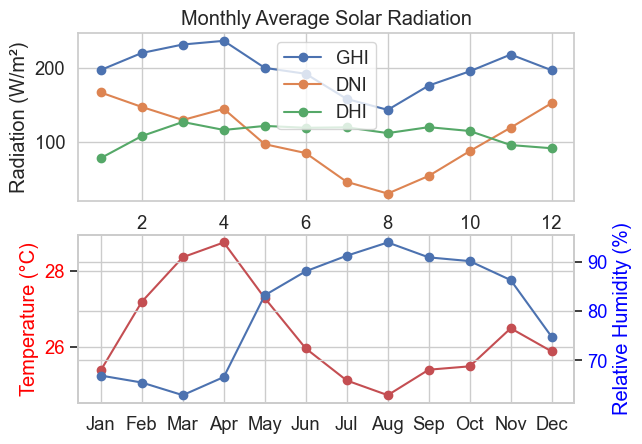

In [24]:
# Plot solar radiation variables
plt.subplot(2, 1, 1)
plt.plot(monthly_data['Month'], monthly_data['GHI'], 'o-', label='GHI')
plt.plot(monthly_data['Month'], monthly_data['DNI'], 'o-', label='DNI')
plt.plot(monthly_data['Month'], monthly_data['DHI'], 'o-', label='DHI')
plt.title('Monthly Average Solar Radiation')
plt.ylabel('Radiation (W/m²)')
plt.grid(True)
plt.legend()

# Plot temperature and humidity
ax1 = plt.subplot(2, 1, 2)
line1 = ax1.plot(monthly_data['Month'], monthly_data['Tamb'], 'ro-', label='Temperature')
ax1.set_ylabel('Temperature (°C)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
line2 = ax2.plot(monthly_data['Month'], monthly_data['RH'], 'bo-', label='Humidity')
ax2.set_ylabel('Relative Humidity (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

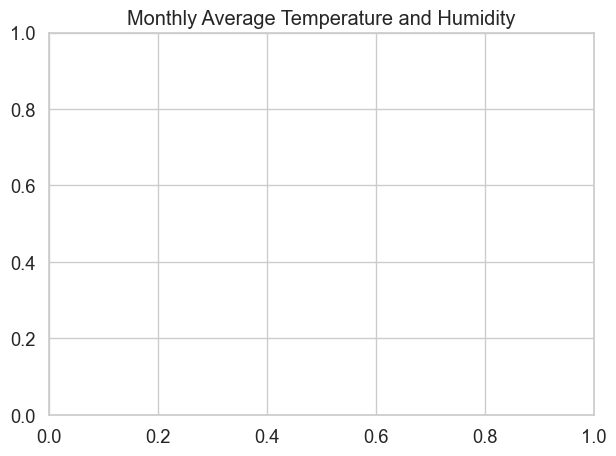

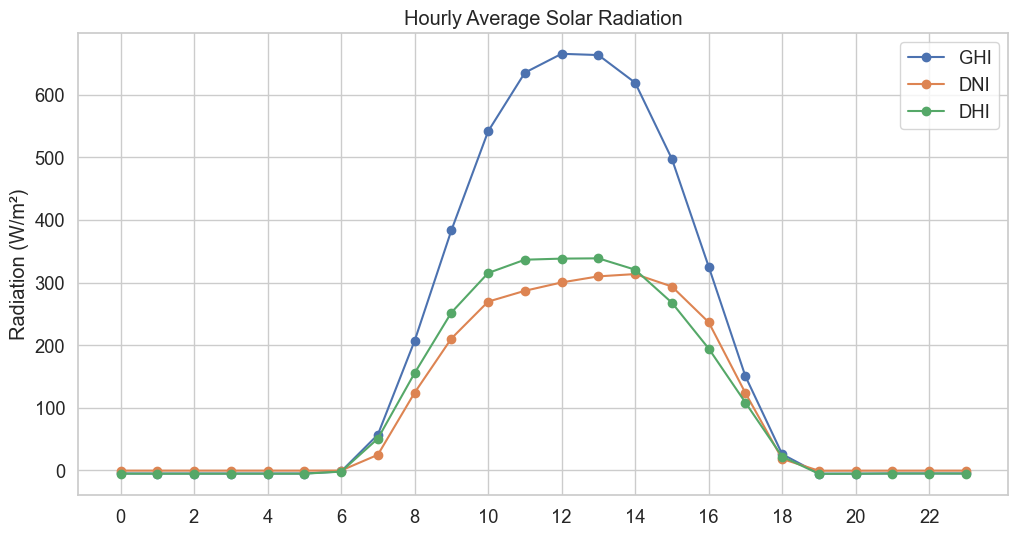

In [25]:
# Add both legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

plt.title('Monthly Average Temperature and Humidity')
plt.grid(True)
plt.tight_layout()
plt.show()

# Hourly patterns
hourly_data = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS']].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_data['Hour'], hourly_data['GHI'], 'o-', label='GHI')
plt.plot(hourly_data['Hour'], hourly_data['DNI'], 'o-', label='DNI')
plt.plot(hourly_data['Hour'], hourly_data['DHI'], 'o-', label='DHI')
plt.title('Hourly Average Solar Radiation')
plt.ylabel('Radiation (W/m²)')
plt.xticks(range(0, 24, 2))
plt.legend()
plt.grid(True)

## 5. Correlation Analysis

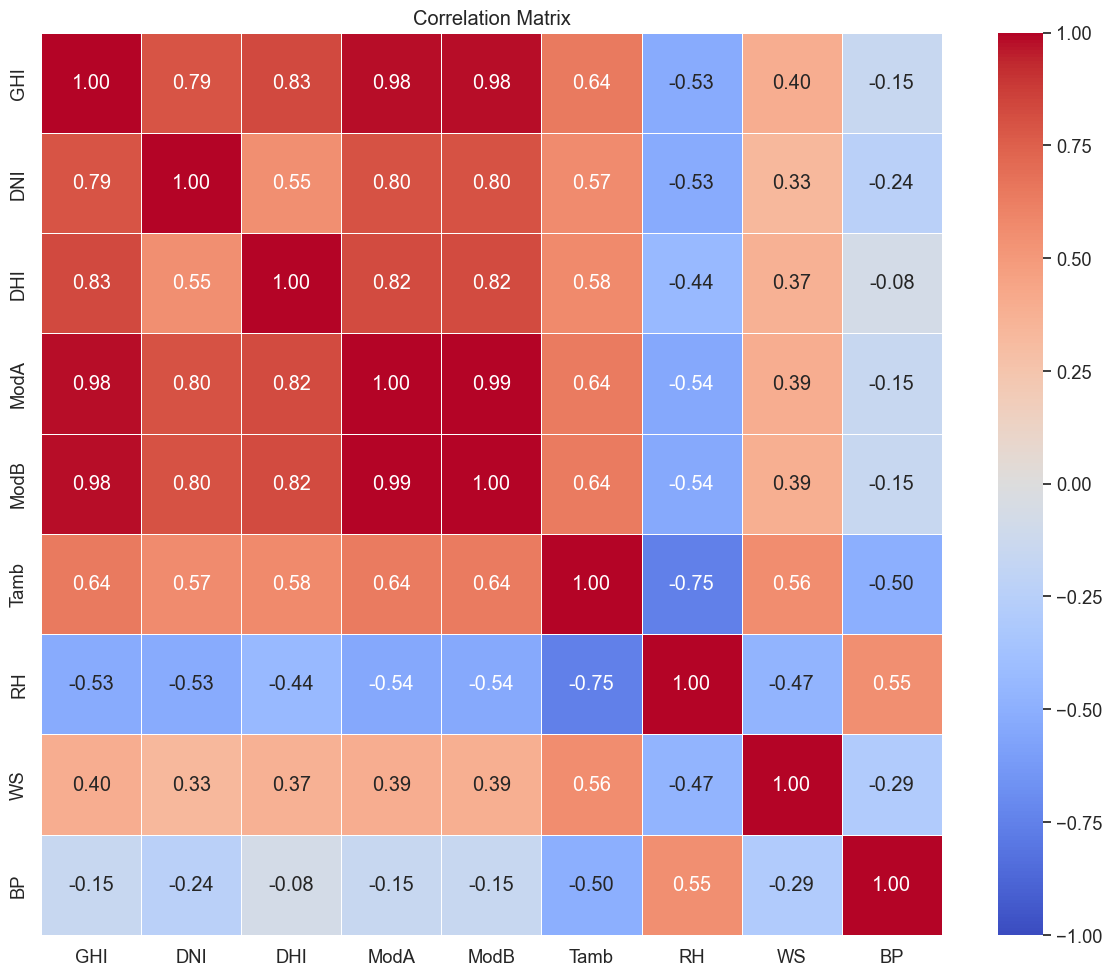

In [26]:
# Select relevant columns for correlation analysis
corr_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'BP']
corr_matrix = df_clean[corr_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## 6. Scatter Plot Analysis

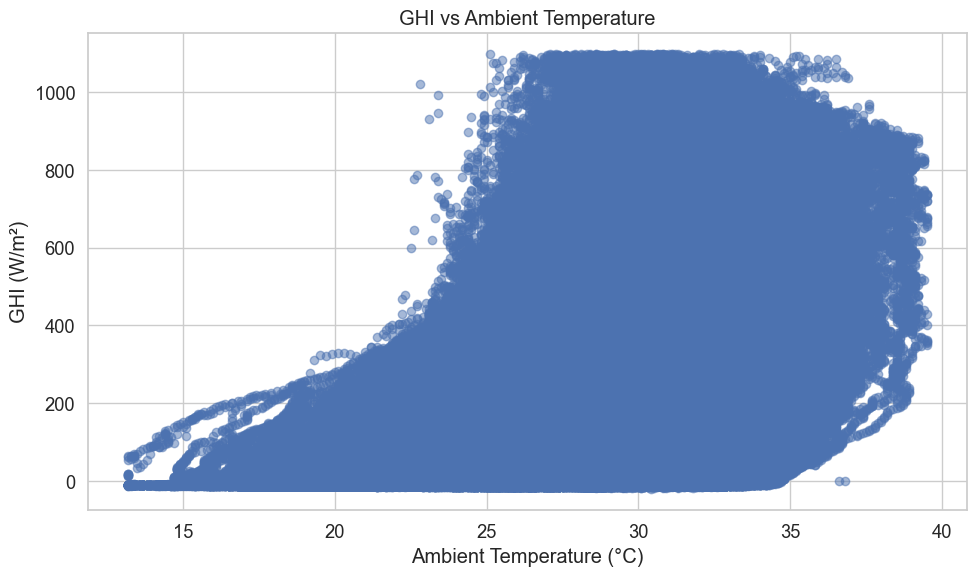

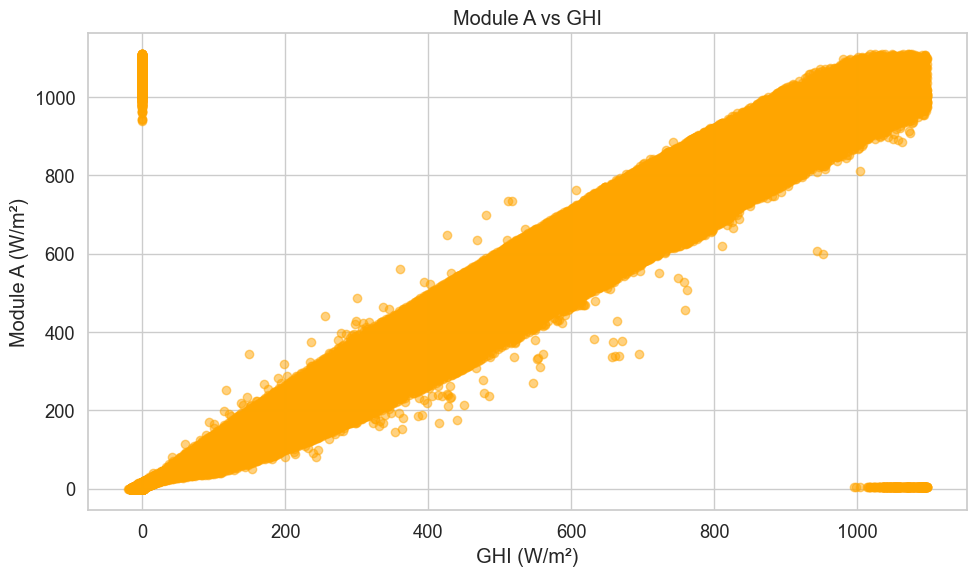

In [27]:
# GHI vs Temperature
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['Tamb'], df_clean['GHI'], alpha=0.5)
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Ambient Temperature')
plt.grid(True)
plt.tight_layout()
plt.show()

# ModA vs GHI
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['GHI'], df_clean['ModA'], alpha=0.5, color='orange')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Module A (W/m²)')
plt.title('Module A vs GHI')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Wind Analysis and Distribution

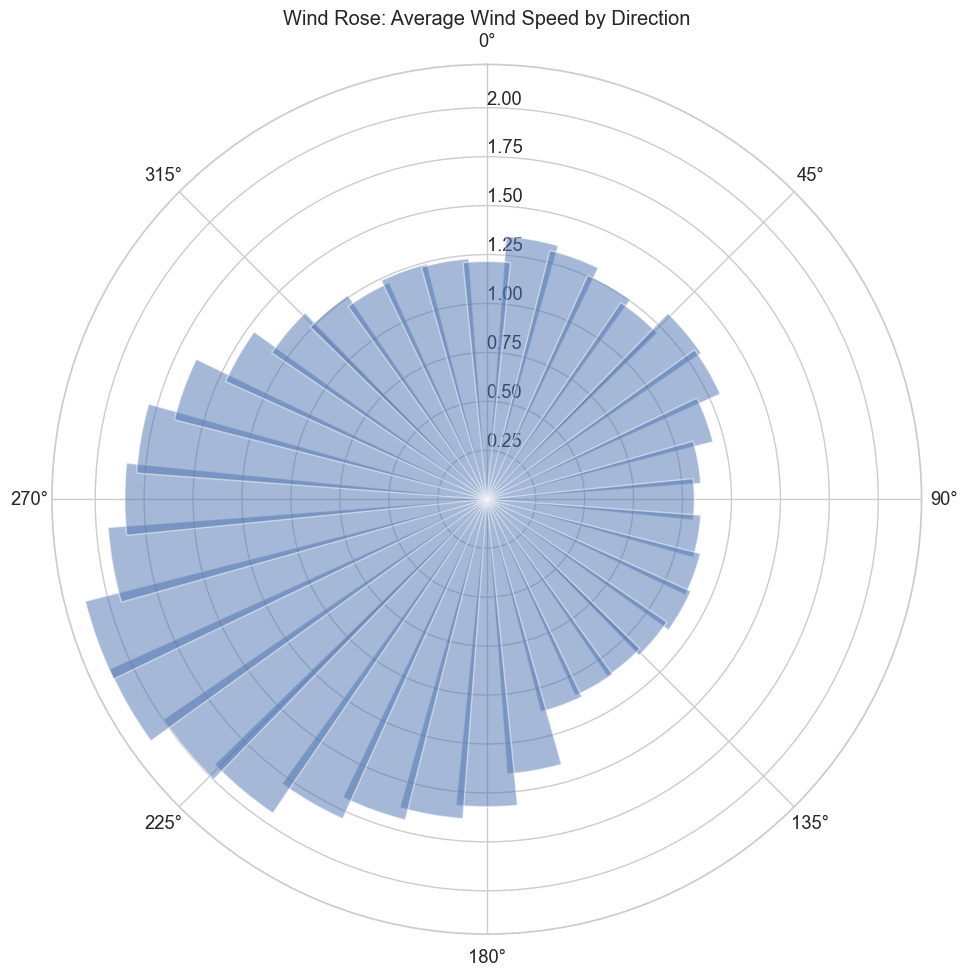

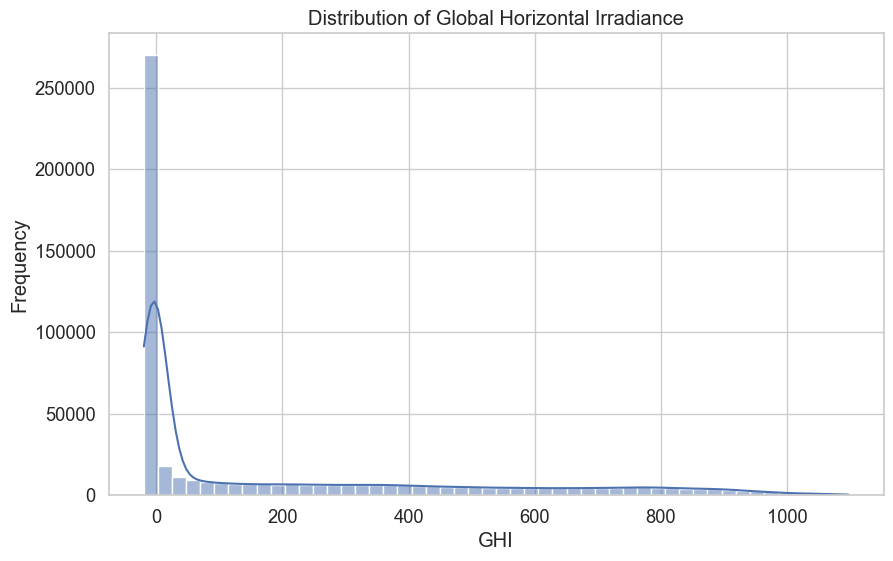

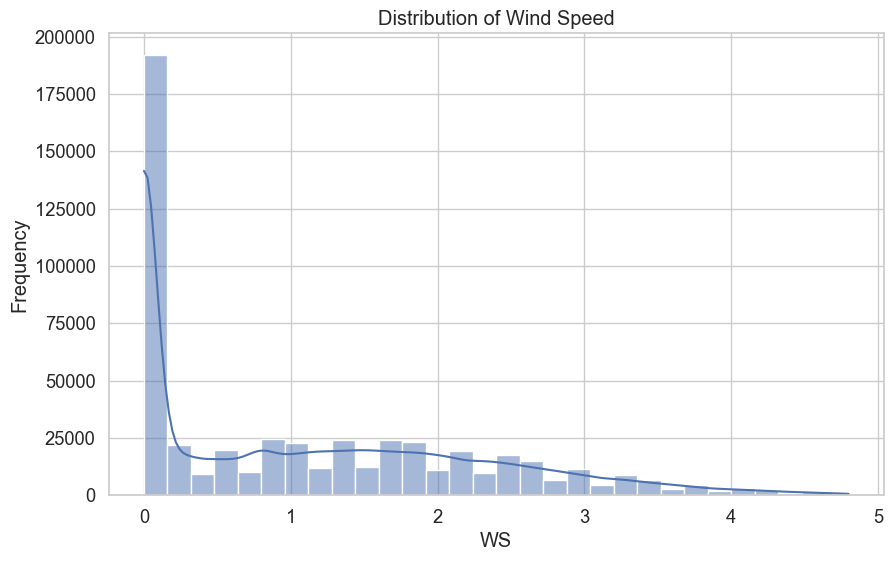

In [28]:
# 7.1 Wind direction analysis
# First, round wind direction to the nearest 10 degrees
df_clean['WD_rounded'] = (df_clean['WD'] / 10).round() * 10

# Calculate average wind speed for each direction
wind_rose_data = df_clean.groupby('WD_rounded')['WS'].mean().reset_index()

# Create wind rose plot
plt.figure(figsize=(10, 10), facecolor='white')
ax = plt.subplot(111, polar=True)
theta = np.radians(wind_rose_data['WD_rounded'])
radii = wind_rose_data['WS']
bars = ax.bar(theta, radii, width=0.2, bottom=0, alpha=0.5)

# Set the direction labels
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)  # Clockwise
ax.set_rlabel_position(0)
ax.set_title('Wind Rose: Average Wind Speed by Direction')
plt.tight_layout()
plt.show()

# 7.2 Histograms
# GHI histogram
plot_histogram(df_clean, 'GHI', bins=50, title='Distribution of Global Horizontal Irradiance')
plt.show()

# Wind Speed histogram
plot_histogram(df_clean, 'WS', bins=30, title='Distribution of Wind Speed')
plt.show()

## 8. Environmental Relationships

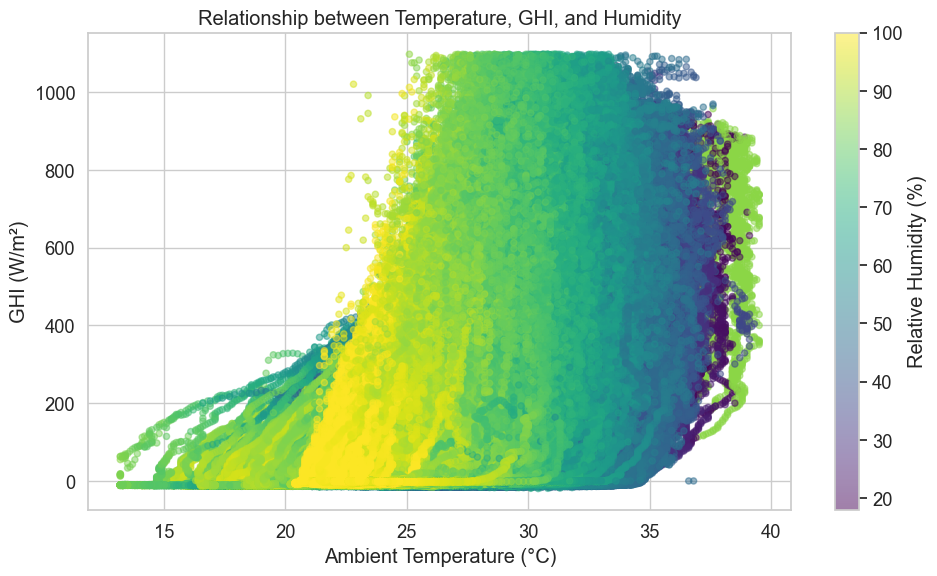

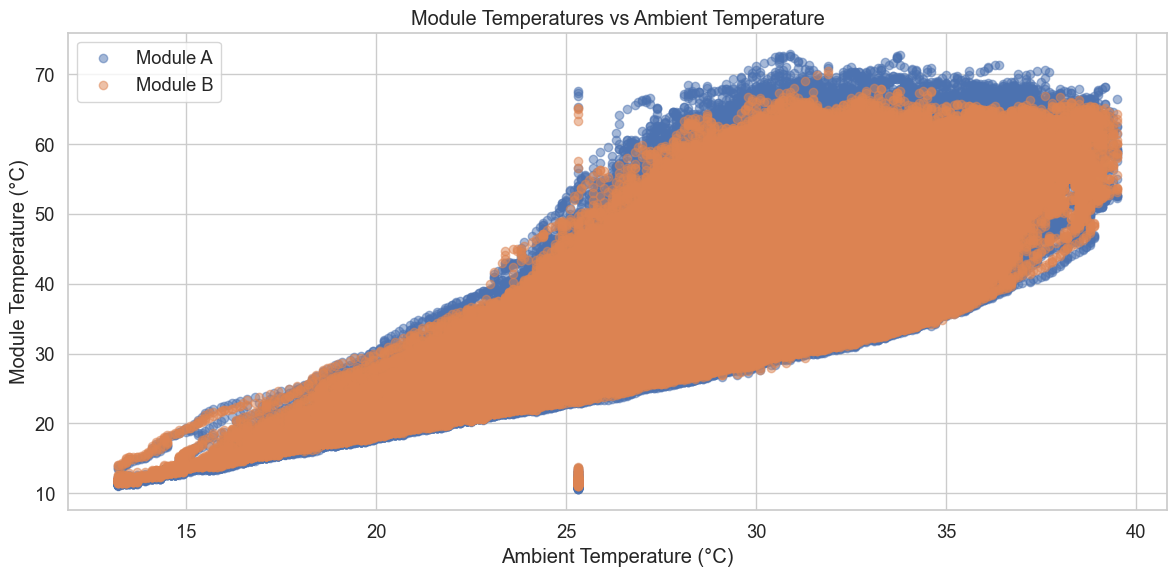

In [29]:
# Examine relationship between RH, temperature and GHI
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_clean['Tamb'], df_clean['GHI'], c=df_clean['RH'], 
                    cmap='viridis', alpha=0.5, s=20)
plt.colorbar(scatter, label='Relative Humidity (%)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.title('Relationship between Temperature, GHI, and Humidity')
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.1 Additional temperature analysis: TModA, TModB vs Tamb
plt.figure(figsize=(12, 6))
plt.scatter(df_clean['Tamb'], df_clean['TModA'], alpha=0.5, label='Module A')
plt.scatter(df_clean['Tamb'], df_clean['TModB'], alpha=0.5, label='Module B')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('Module Temperature (°C)')
plt.title('Module Temperatures vs Ambient Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Summary of Findings

In [ ]:
print("\n=== Summary of Findings for Sierra Leone Solar Data Analysis ===")
print(f"Total observations: {df.shape[0]}")
print(f"Date range: {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}")
print(f"Average GHI: {df_clean['GHI'].mean():.2f} W/m²")
print(f"Average DNI: {df_clean['DNI'].mean():.2f} W/m²")
print(f"Average DHI: {df_clean['DHI'].mean():.2f} W/m²")
print(f"Average ambient temperature: {df_clean['Tamb'].mean():.2f} °C")
print(f"Average relative humidity: {df_clean['RH'].mean():.2f} %")
print(f"Average wind speed: {df_clean['WS'].mean():.2f} m/s")
print("\nCleaned data saved to:", clean_data_path)